# Music Genre Classification ChatBot

### Importing Libraries for ChatBot

In [2]:
import nltk
import numpy as np
import tflearn
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import random
import json
import pickle
from tkinter import *
import pyttsx3 as pp
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)






Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


### Importing Libraries for Classification Model

In [3]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.metrics import mean_squared_error
from math import sqrt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

#### Extracting music and features

##### Dataset

We use GTZAN genre collection dataset for classification. 

The dataset consists of 10 genres i.e
 * Blues
 * Classical
 * Country
 * Disco
 * Hiphop
 * Jazz
 * Metal
 * Pop
 * Reggae
 * Rock
 
Each genre contains 100 songs. Total dataset: 1000 songs

### Extracting the Spectrogram for every Audio


In [3]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'C:/Users/Rishit Jain/genres/{g}'):
        songname = f'C:/Users/Rishit Jain/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
 

<Figure size 720x720 with 0 Axes>

All the audio files get converted into their respective spectrograms. We can now easily extract the features from them.

#### Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [4]:
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

#### Writing data to csv file

We write the data to a csv file 

In [5]:
file = open('GenreData.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'C:/Users/Rishit Jain/genres/{g}'):
        songname = f'C:/Users/Rishit Jain/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        #rsme= sqrt(mean_squared_error(y,sr))
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('GenreData.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

The data has been extracted into a data.csv file.

#### Analysing the Data in Pandas

In [6]:
data = pd.read_csv('GenreData.csv')
data.tail()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
995,rock.00095.au,0.351991,2008.581132,2106.617024,4254.215942,0.089267,-153.632309,109.857262,-23.085709,59.040676,...,12.350817,-12.306271,5.780973,-10.279924,1.791489,-13.304210,2.473193,-6.717574,-1.189238,rock
996,rock.00096.au,0.398653,2006.051164,2068.327905,4147.374921,0.097659,-142.424210,116.219780,-32.177074,49.122974,...,14.065347,-16.394691,4.152589,-4.350760,3.736455,-10.845638,1.875218,-7.459579,-2.802677,rock
997,rock.00097.au,0.432103,2077.190361,1926.989678,4030.767293,0.121824,-125.031326,115.194977,-47.993507,52.834534,...,10.481962,-17.951916,1.211113,-11.534864,1.844774,-12.847901,3.447425,-12.594178,-2.107002,rock
998,rock.00098.au,0.362349,1398.672358,1818.148469,3014.740104,0.048731,-224.972305,123.656891,-9.754534,56.595062,...,7.683082,-10.071786,-0.255098,-5.276486,-2.816288,-4.416438,1.558265,-5.043121,-3.585596,rock
999,rock.00099.au,0.358195,1609.442919,1797.065098,3246.280370,0.076290,-235.189331,123.888542,-22.536184,52.915520,...,10.066769,-15.019588,3.110468,-7.127754,1.784515,-7.070405,0.023643,-2.022034,1.158525,rock


In [7]:
data.shape

(1000, 27)

In [8]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

#### Encoding the Labels

In [9]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
print(genre_list)

0      blues
1      blues
2      blues
3      blues
4      blues
       ...  
995     rock
996     rock
997     rock
998     rock
999     rock
Name: label, Length: 1000, dtype: object


#### Scaling the Feature columns

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
print(X)

[[-0.35174835 -0.58330334 -0.45603703 ... -0.23719143  0.00761132
   0.60349827]
 [-0.46146555 -0.93906628 -0.38766764 ... -0.05518971  0.54382353
   0.42403527]
 [-0.18448354 -0.90741936 -0.94167974 ... -0.60070696 -0.29428465
  -0.29511276]
 ...
 [ 0.6543177  -0.17418012 -0.59985796 ...  0.76028073 -2.73474441
  -0.2638744 ]
 [-0.19983743 -1.12235633 -0.80675114 ...  0.27176634 -0.72311177
  -0.64936233]
 [-0.25070237 -0.82782084 -0.84682792 ... -0.1250688   0.08171805
   0.58748954]]


#### Dividing data into Training and Testing set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
len(y_train)

800

In [13]:
len(y_test)

200

In [14]:
X_train[100]

array([ 0.71651714,  1.67577287,  1.57341453,  1.57596856,  1.48518779,
        0.96649364, -1.40536966,  1.29600371, -0.70891668,  0.42449554,
       -1.10608979,  1.21741403, -1.06756269,  1.21710291, -0.74845904,
        0.43756459, -0.37823805,  0.01919977, -0.85902104,  0.61753051,
       -0.75043172,  0.50043085, -0.96655677,  1.31697832,  0.77932944])

### Classification with Keras

#### Building our Network

In [15]:
from keras import models
from keras import layers

modelC = models.Sequential()
modelC.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
modelC.add(layers.Dense(128, activation='relu'))
modelC.add(layers.Dense(64, activation='relu'))
modelC.add(layers.Dense(10, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
modelC.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])




Epoch 1/25
800/800 [==============================] - 0s 199us/step - loss: 1.8548 - accuracy: 0.3250
Epoch 2/25
800/800 [==============================] - 0s 56us/step - loss: 1.3382 - accuracy: 0.5138
Epoch 3/25
800/800 [==============================] - 0s 57us/step - loss: 1.1354 - accuracy: 0.5962
Epoch 4/25
800/800 [==============================] - 0s 52us/step - loss: 0.9762 - accuracy: 0.6625
Epoch 5/25
800/800 [==============================] - 0s 51us/step - loss: 0.8607 - accuracy: 0.6988
Epoch 6/25
800/800 [==============================] - 0s 51us/step - loss: 0.8126 - accuracy: 0.7063
Epoch 7/25
800/800 [==============================] - 0s 49us/step - loss: 0.7132 - accuracy: 0.7462
Epoch 8/25
800/800 [==============================] - 0s 49us/step - loss: 0.6561 - accuracy: 0.7700
Epoch 9/25
800/800 [==============================] - 0s 51us/step - loss: 0.5757 - accuracy: 0.8075
Epoch 10/25
800/800 [==============================] - 0s 47us/step - loss: 0.5061 - ac

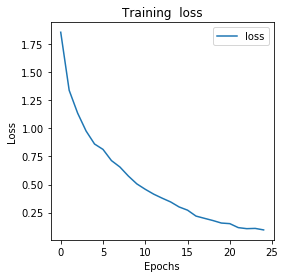

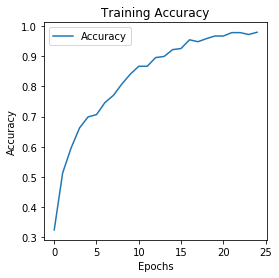

In [17]:
history= modelC.fit(X_train,
                    y_train,
                    epochs=25,
                    batch_size=16)
plt.figure(figsize=(4,4))
loss_train = history.history['loss']
#loss_val = history.history['val_los']
epochs = range(1,25)
plt.plot(history.history['loss'])

plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss'])
plt.show()

plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy'])

In [18]:
test_loss, test_acc = modelC.evaluate(X_test,y_test)

200/200 [==============================] - 0s 95us/step


In [19]:
print('test_acc: ',test_acc)

test_acc:  0.6899999976158142


#### Validating the Model by using 200 files from the dataset

In [20]:
x_val = X_train[:200]
partial_x_train = X_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]

In [21]:
modelCt = models.Sequential()
modelCt.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
modelCt.add(layers.Dense(256, activation='relu'))
modelCt.add(layers.Dense(128, activation='relu'))
modelCt.add(layers.Dense(64, activation='relu'))
modelCt.add(layers.Dense(10, activation='softmax'))

modelCt.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

xyz = modelCt.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=20,
          validation_data=(x_val, y_val))
results = modelCt.evaluate(X_test, y_test)
modelCt.save("modelC.h5")

Train on 600 samples, validate on 200 samples
Epoch 1/20
600/600 [==============================] - 0s 273us/step - loss: 1.8748 - accuracy: 0.3267 - val_loss: 1.5752 - val_accuracy: 0.4650
Epoch 2/20
600/600 [==============================] - 0s 98us/step - loss: 1.3661 - accuracy: 0.4933 - val_loss: 1.2419 - val_accuracy: 0.5100
Epoch 3/20
600/600 [==============================] - 0s 91us/step - loss: 1.1253 - accuracy: 0.5967 - val_loss: 1.3445 - val_accuracy: 0.5300
Epoch 4/20
600/600 [==============================] - 0s 91us/step - loss: 1.0590 - accuracy: 0.6067 - val_loss: 1.1075 - val_accuracy: 0.5850
Epoch 5/20
600/600 [==============================] - 0s 88us/step - loss: 0.8724 - accuracy: 0.6917 - val_loss: 1.1759 - val_accuracy: 0.6100
Epoch 6/20
600/600 [==============================] - 0s 95us/step - loss: 0.7807 - accuracy: 0.7000 - val_loss: 1.1171 - val_accuracy: 0.6350
Epoch 7/20
600/600 [==============================] - 0s 90us/step - loss: 0.6893 - accuracy: 0

In [22]:
modelCt = load_model("modelC.h5") # Loading the model if it already exists
modelCt

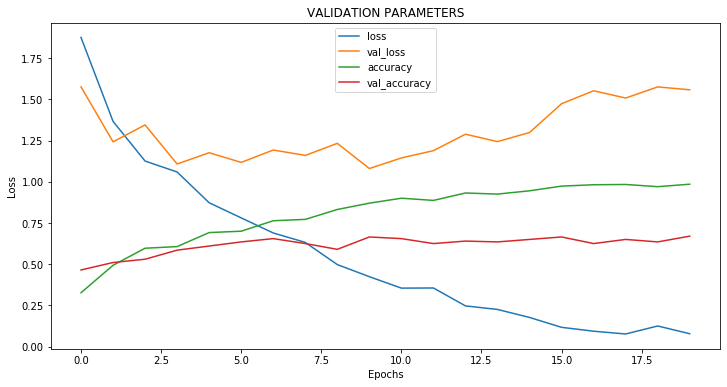

In [23]:
plt.figure(figsize=(12,6))
plt.plot(xyz.history['loss'])
plt.plot(xyz.history['val_loss'])
plt.plot(xyz.history['accuracy'])
plt.plot(xyz.history['val_accuracy'])
plt.title('VALIDATION PARAMETERS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.show()


In [24]:
results

[1.4872745227813722, 0.6949999928474426]

In [25]:
test_loss, test_acc = modelCt.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

200/200 [==============================] - 0s 200us/step
test_acc:  0.6949999928474426


In [26]:
print(genre_list[0:200])

0          blues
1          blues
2          blues
3          blues
4          blues
         ...    
195    classical
196    classical
197    classical
198    classical
199    classical
Name: label, Length: 200, dtype: object


### Defining and training the Model for the Chatbot

In [27]:
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()

In [5]:
# with open("chatbotintents.json") as file:
file = open("intents.json")
data = json.load(file)

try:    
    with open("data.pickle", "rb") as f:   # reading in bytes
        words, labels, training, output = pickle.load(f)
except:
    words = []
    labels = []
    docs_x = []
    docs_y = []

    for intent in data["intents"]:
        for pattern in intent["patterns"]:
            wrds = nltk.word_tokenize(pattern)
            words.extend(wrds)
            docs_x.append(wrds)
            docs_y.append(intent["tag"])

            if intent["tag"] not in labels:
                labels.append(intent["tag"])

    words = [stemmer.stem(w.lower()) for w in words if w not in "?"]
    words = sorted(list(set(words)))

    labels = sorted(labels)

    training = []
    output = []

    out_empty = [0 for _ in range(len(labels))]

    # Applying one hot encoding

    for x, doc in enumerate(docs_x):
        bag = []

        wrds = [stemmer.stem(w) for w in doc]

        for w in words:
            if w in wrds:
                bag.append(1)
            else:
                bag.append(0)
        output_row = out_empty[:]
        output_row[labels.index(docs_y[x])] = 1

        training.append(bag)
        output.append(output_row)

    training = np.array(training)
    output = np.array(output)
    
    with open("data.pickle", "wb") as f:  # writing in bytes
        pickle.dump((words, labels, training, output), f)

    
tf.reset_default_graph()

net = tflearn.input_data(shape=[None, len(training[0])])
net = tflearn.fully_connected(net, 8)
net = tflearn.fully_connected(net, 8)
net = tflearn.fully_connected(net, len(output[0]), activation='softmax')
net = tflearn.regression(net)

# DNN - Deep Neural Network applied to the hidden layers to prepare the model.
model = tflearn.DNN(net)
model.fit(training, output, n_epoch = 1000, batch_size = 8, show_metric = True)
model.save("mymodel.tflearn")


Training Step: 3999  | total loss: 0.01274 | time: 0.006s
| Adam | epoch: 1000 | loss: 0.01274 - acc: 0.9999 -- iter: 24/26
Training Step: 4000  | total loss: 0.01242 | time: 0.007s
| Adam | epoch: 1000 | loss: 0.01242 - acc: 0.9999 -- iter: 26/26
--
INFO:tensorflow:C:\Users\Rishit Jain\mymodel.tflearn is not in all_model_checkpoint_paths. Manually adding it.


In [29]:
try: 
    model.load("mymodel.tflearn") # Loading the model if it already exists
except:
    # Training the Model and then Saving it
    model.fit(training, output, n_epoch = 20000, batch_size = 8, show_metric = True)
    model.save("mymodel.tflearn")

INFO:tensorflow:Restoring parameters from C:\Users\Rishit Jain\mymodel.tflearn


### Building a Framework for the ChatBot

In [30]:
# model.load("mymodel.tflearn")

# Defining the process which takes place on the user input

def bag_of_words(s, words):
    bag = [0 for _ in range(len(words))]
    
    s_words = nltk.word_tokenize(s)
    s_words = [stemmer.stem(word.lower()) for word in s_words]
    
    for se in s_words:
        for i, w in enumerate(words):
            if w == se:
                bag[i] = 1
                
    return np.array(bag) 

In [31]:
# Defining the Chatting Feature
# Defining the Chatting Feature
def chat():

    while True: 
        inp = input("You: ")
        if inp.lower() == "quit" or inp.lower() == "exit":
            break
        
        # This will only return the probabilities assigned to each tag / perceptron
        results = model.predict([bag_of_words(inp, words)])
        # To get the actual message
        results_index = np.argmax(results)
        tag = labels[results_index]
        
        for tg in data["intents"]:
            if tg["tag"] == tag:
                responses = tg["responses"]
            elif inp == "Please run the Genre Classifier" or inp == "genre classifier" or inp == "genre?" or inp == "Run the classifier please": 
                modelCt = load_model("modelC.h5")
                test_loss, test_acc = modelCt.evaluate(X_test,y_test)
                print('The Accuracy of the Classifier: ',test_acc)
                print(genre_list[0:200])
                break
                
        botAns = random.choice(responses)
        print(botAns)
    

In [39]:
chat()

You: Hi
Good to see you again!
You: Please run the Genre Classifier
200/200 [==============================] - 0s 469us/step
The Accuracy of the Classifier:  0.6949999928474426
0          blues
1          blues
2          blues
3          blues
4          blues
         ...    
195    classical
196    classical
197    classical
198    classical
199    classical
Name: label, Length: 200, dtype: object
Good to see you again!
You: What is your name?
I'm G-Bot!
You: quit
